In [8]:
"""Toy code implementing the time evolving block decimation (TEBD)."""

import numpy as np
from scipy.linalg import expm
from a_mps import split_truncate_theta


In [13]:
"""Toy code implementing the transverse-field ising model and
   the ising model with a transverse and longitudinal field."""

import numpy as np


class TFIModel:
    """Class generating the Hamiltonian of the transverse-field Ising model.

    The Hamiltonian reads
    .. math ::
        H = - J \\sum_{i} \\sigma^x_i \\sigma^x_{i+1} - g \\sum_{i} \\sigma^z_i

    Parameters
    ----------
    L : int
        Number of sites.
    J, g : float
        Coupling parameters of the above defined Hamiltonian.

    Attributes
    ----------
    L : int
        Number of sites.
    d : int
        Local dimension (=2 for spin-1/2 of the transverse field ising model)
    sigmax, sigmay, sigmaz, id :
        Local operators, namely the Pauli matrices and identity.
    H_bonds : list of np.Array[ndim=4]
        The Hamiltonian written in terms of local 2-site operators, ``H = sum_i H_bonds[i]``.
        Each ``H_bonds[i]`` has (physical) legs (i out, (i+1) out, i in, (i+1) in),
        in short ``i j i* j*``.
    """

    def __init__(self, L, J, g, h):
        self.L, self.d = L, 2
        self.J, self.g, self.h = J, g, h

        self.sigmax = np.array([[0., 1.], [1., 0.]])
        self.sigmay = np.array([[0., -1j], [1j, 0.]])
        self.sigmaz = np.array([[1., 0.], [0., -1.]])
        self.id = np.eye(2)
        self.init_H_bonds()

    def init_H_bonds(self):
        """Initialize `H_bonds` hamiltonian. Called by __init__()."""
        sx, sz, id = self.sigmax, self.sigmaz, self.id
        d = self.d
        H_list = []
        for i in range(self.L - 1):
            gL = gR = 0.5 * self.g
            hL = hR = 0.5 * self.h
            if i == 0: # first bond
                gL = self.g
                hL = self.h
            if i + 1 == self.L - 1: # last bond
                gR = self.g
                hR = self.h

            H_bond = -self.J * np.kron(sx, sx) - gL * np.kron(sz, id) - gR * np.kron(id, sz) - hL * np.kron(sx, id) - hR * np.kron(id, sx)                
            # H_bond has legs ``i, j, i*, j*``
            H_list.append(np.reshape(H_bond, [d, d, d, d]))
        self.H_bonds = H_list

    def energy(self, psi):
        """Evaluate energy E = <psi|H|psi> for the given MPS."""
        assert psi.L == self.L
        return np.sum(psi.bond_expectation_value(self.H_bonds))


In [12]:


def calc_U_bonds(model, dt):
    """Given a model, calculate ``U_bonds[i] = expm(-dt*model.H_bonds[i])``.

    Each local operator has legs (i out, (i+1) out, i in, (i+1) in), in short ``i j i* j*``.
    Note that no imaginary 'i' is included, thus real `dt` means imaginary time evolution!
    """
    H_bonds = model.H_bonds
    d = H_bonds[0].shape[0]
    U_bonds = []
    for H in H_bonds:
        H = np.reshape(H, [d * d, d * d])
        U = expm(-dt * H)
        U_bonds.append(np.reshape(U, [d, d, d, d]))
    return U_bonds



In [26]:

def run_TEBD(psi, U_bonds, N_steps, chi_max, eps):
    """Evolve the state `psi` for `N_steps` time steps with (first order) TEBD.

    The state psi is modified in place."""
    Nbonds = psi.L - 1
    assert len(U_bonds) == Nbonds
    for n in range(N_steps):
        for k in [0, 1]:  # even, odd
            for i_bond in range(k, Nbonds, 2):
                update_bond(psi, i_bond, U_bonds[i_bond], chi_max, eps)
    # done



In [11]:

def update_bond(psi, i, U_bond, chi_max, eps):
    """Apply `U_bond` acting on i,j=(i+1) to `psi`."""
    j = i + 1
    # construct theta matrix
    theta = psi.get_theta2(i)  # vL i j vR
    # apply U
    Utheta = np.tensordot(U_bond, theta, axes=([2, 3], [1, 2]))  # i j [i*] [j*], vL [i] [j] vR
    Utheta = np.transpose(Utheta, [2, 0, 1, 3])  # vL i j vR
    # split and truncate
    Ai, Sj, Bj = split_truncate_theta(Utheta, chi_max, eps)
    # put back into MPS
    Gi = np.tensordot(np.diag(psi.Ss[i]**(-1)), Ai, axes=[1, 0])  # vL [vL*], [vL] i vC
    psi.Bs[i] = np.tensordot(Gi, np.diag(Sj), axes=[2, 0])  # vL i [vC], [vC] vC
    psi.Ss[j] = Sj  # vC
    psi.Bs[j] = Bj  # vC j vR



In [10]:


def example_TEBD_gs_finite(L, J, g):
    print("finite TEBD, (imaginary time evolution)")
    print("L={L:d}, J={J:.1f}, g={g:.2f}".format(L=L, J=J, g=g))
    import a_mps
    # import b_model
    model = TFIModel(L, J=J, g=g, h=0)
    psi = a_mps.init_spinup_MPS(L)
    for dt in [0.1, 0.01, 0.001, 1.e-4, 1.e-5]:
        U_bonds = calc_U_bonds(model, dt)
        run_TEBD(psi, U_bonds, N_steps=500, chi_max=100, eps=1.e-10)
        E = model.energy(psi)
        print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
    print("final bond dimensions: ", psi.get_chi())
    return E, psi, model



In [22]:

if __name__ == "__main__":
    example_TEBD_gs_finite(L=14, J=1., g=1.5)


finite TEBD, (imaginary time evolution)
L=14, J=1.0, g=1.50
dt = 0.10000: E = -23.1210722544100
dt = 0.01000: E = -23.2133644786914
dt = 0.00100: E = -23.2220037685472
dt = 0.00010: E = -23.2228606166766
dt = 0.00001: E = -23.2229463553360
final bond dimensions:  [2, 4, 8, 13, 17, 18, 18, 18, 17, 13, 8, 4, 2]


In [41]:
def calc_correlation_func(op1, op2, psi, site):
    L = psi.L
    contraction = psi.get_theta1(site)

    result = []
    result.append(
    psi.site_expectation_value(
        np.tensordot(op1, op2, (1,0))
        )[site]
    )

    for j in range(site + 1, L, 1):
        # init contraction again
        contraction = psi.get_theta1(site) #vL, i, vR
        op_theta = np.tensordot(op1, contraction, axes=[1, 1]) # i [i*]   |   vL [i] vR  --> i, vL, vR
        # [vL*], [i*], vR*  |   [i], [vL], vR 
        contraction = np.tensordot(contraction.conj(), op_theta, [[0, 1], [1, 0]]) # vR* vR 

        # contract until we arrive at position of op2 (index j)
        for k in range(site + 1, j, 1):
            # [vL] i vR | vR* [vR]
            op_theta = np.tensordot(psi.Bs[k], contraction, [0, 1]) # i vR vR*
            # [vL]* i* vR* | i vR vR*
            contraction = np.tensordot(psi.Bs[k].conj(), op_theta, [[0, 1], [2, 0]]) # vR* vR

        # contract with op2
        # [vL] i vR | vR* vR
        op_theta = np.tensordot(psi.Bs[j], contraction, [0, 1]) # i vR vR* 
        # i [i*] | i vR vR*
        op_theta = np.tensordot(op2, op_theta, [1, 0]) # i vR vR*
        #  [vL]* i* vR*  | i vR vR*
        contraction = np.tensordot(psi.Bs[j].conj(), op_theta, [[0, 1], [2 , 0]]) # vR* vR

        # contract until end
        for k in range(j + 1, L, 1):
            # [vL] i vR | vR* vR
            op_theta = np.tensordot(psi.Bs[k], contraction, [0, 1]) # i vR vR*
            # [vL]* i* vR* | i vR vR*
            contraction = np.tensordot(psi.Bs[k].conj(), op_theta, [[0, 1], [2, 0]]) # vR* vR

        result.append(
        np.trace(contraction)
        )

    return np.array(result)



In [43]:
from c_tebd import run_TEBD 
from a_mps import init_spinup_MPS
import matplotlib.pyplot as plt


sigmaX = np.array([[0., 1.],[1., 0.]])


L = 30
gs = np.linspace(0.3,1.5,4)
# t_final
J = 1

psis = []

for g in gs:
    E, psi, model = example_TEBD_gs_finite(L, J, g)
    psis.append(psi)


finite TEBD, (imaginary time evolution)
L=30, J=1.0, g=0.30
dt = 0.10000: E = -29.7237778057965
dt = 0.01000: E = -29.7243442589172
dt = 0.00100: E = -29.7244030096187
dt = 0.00010: E = -29.7244089062471
dt = 0.00001: E = -29.7244094959373
final bond dimensions:  [2, 4, 8, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 8, 4, 2]
finite TEBD, (imaginary time evolution)
L=30, J=1.0, g=0.47
dt = 0.10000: E = -30.8020025213167
dt = 0.01000: E = -30.8055056150777
dt = 0.00100: E = -30.8058627785883
dt = 0.00010: E = -30.8058985786382
dt = 0.00001: E = -30.8059021588407
final bond dimensions:  [2, 4, 8, 14, 18, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 18, 14, 8, 4, 2]
finite TEBD, (imaginary time evolution)
L=30, J=1.0, g=0.64
dt = 0.10000: E = -32.3950762064312
dt = 0.01000: E = -32.4075747072691
dt = 0.00100: E = -32.4088141220436
dt = 0.00010: E = -32.4089380720924
dt = 0.00001: E = -32.4089504680253
final bond

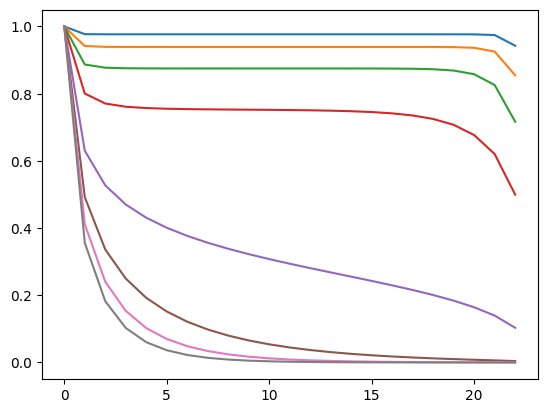

In [44]:

for i in psis:
    # psi = a_mps.init_spinup_MPS(L)
    # model = TFIModel(L, 1, g, 0)
    # corrs = []
    # for dt in [0.1, 0.01, 0.001, 1.e-4, 1.e-5]:
    #     U_bonds = calc_U_bonds(model,dt)
    #     run_TEBD(psi, U_bonds, 500, 100, 1.e-5)
    #     corrs.append(calc_correlation_function(sigmaX, sigmaX, psi, L//4))
    # plt.plot()

    corrs = calc_correlation_func(sigmaX, sigmaX, i, L//4)
    plt.plot(np.arange(0, len(corrs)), corrs)

plt.show()



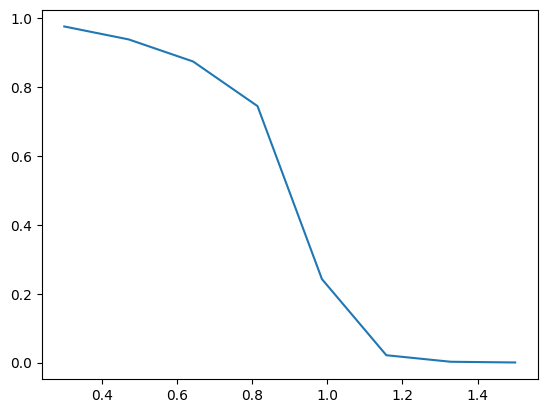

In [45]:
corrs = []
for psi in psis:
    corrs.append(calc_correlation_func(sigmaX, sigmaX, psi, L//4)[-L//4])

plt.plot(gs, corrs)
plt.show()



In [45]:
def calc_contraction_func(psi1, psi2):
    L = psi.L
    site = 0

    top = psi1.get_theta1(site)
    bottom = psi2.get_theta1(site).conj()

    result = []

    # vL i vR | vL* i * vR*
    contraction = np.tensordot(top, bottom,[[0, 1], [0, 1]]) #  vR  vR*

    result.append(contraction)

    for j in range(site+1, L, 1):
        top = psi1.Bs[j]
        bottom = psi2.Bs[j].conj()

        # print(j)
        
        # vR vR* | vL i vR
        contraction = np.tensordot(contraction, top, [[0],[0]]) # vR* i vR
        #vR* i vR| vL* i* vR*
        contraction = np.tensordot(contraction, bottom, [[0, 1],[0, 1]]) #  vR vR*

        result.append(contraction)



    return np.array(result)


In [58]:
def calc_contraction_func_final(op1, psi1, psi2):
    contractions = calc_contraction_func(psi1, psi2)

    result = []
    right_contraction = None

    L = psi1.L

    top = psi1.get_theta1(L-1)
    bottom = psi2.get_theta1(L-1).conj()
    # vL i vR | vL* i* vR*
    contraction = np.tensordot(top, bottom, [2, 2]) # vL i vL* i*

    right_contraction = contraction

    # sigma is at rightmost position
    #vL i vL* i* | i i*
    contraction = np.tensordot(contraction, op1, [[1,3],[0,1]]) # vL vL*
    left_contraction = contractions[L-2]
    
    #vR vR* | vL vL*
    result.append(np.tensordot(left_contraction, contraction, [[0, 1],[0, 1]])) 

    for j in range(L-2, -1, -1):


        top = psi1.get_theta1(L-1)
        bottom = psi2.get_theta1(L-1).conj()
        # vL i vR | vL* i* vR*
        contraction = np.tensordot(top, bottom, [[1, 2],[1, 2]]) # vL i vL* i*


        # print(f"j: {j}")
        for k in range(L-2, j, -1):
            # print(f"k: {k}")
            top = psi1.Bs[k]
            bottom = psi2.Bs[k].conj()
            
            # vL vL* | vL i vR
            contraction = np.tensordot(contraction, top, [[0],[2]]) # vL* vL i
            #vL* vL i | vL* i* vR*
            contraction = np.tensordot(contraction, bottom, [[2, 0],[1, 2]]) #  vL vL*

        top = psi1.Bs[j]
        bottom = psi2.Bs[j].conj()
        # vL i vR | vL vL*
        contraction = np.tensordot(top, contraction, [2, 0]) # vL i vL*
        # vL i vL* | i i*
        contraction = np.tensordot(contraction, op1, [1, 0]) # vL vL* i*
        # vL vL* i* | vL* i* vR*
        contraction = np.tensordot(contraction, bottom, [[2, 1],[1, 2]]) # vL vL*
        #vR vR* | vL vL*
        result.append(np.tensordot(contractions[j-1],contraction, [[0, 1],[0, 1]]))
    
    return np.array(result)



In [71]:
#check
from c_tebd import run_TEBD 
from a_mps import init_spinup_MPS
import matplotlib.pyplot as plt


sigmaX = np.array([[0., 1.],[1., 0.]])


L = 30
g = 1.3
# t_final
J = 1

E, psi, model = example_TEBD_gs_finite(L, J, g)



finite TEBD, (imaginary time evolution)
L=30, J=1.0, g=1.30


KeyboardInterrupt: 

[3.78687848e-05 2.69256723e-04 3.94128447e-04 5.43206977e-04
 7.33648477e-04 9.85221924e-04 1.31824133e-03 1.76547894e-03
 2.36322303e-03 3.17163872e-03 4.25889658e-03 5.73872868e-03
 7.74295424e-03 1.04927312e-02 1.42522426e-02 1.94690793e-02
 2.67020880e-02 3.69170405e-02 5.14079718e-02 7.25123447e-02
 1.03786632e-01 1.52437212e-01 2.33015041e-01 3.89871996e-01
 9.22484341e-01 3.88805873e-01 2.31850120e-01 1.49402413e-01
 9.77662711e-02 2.77930124e-15]


/tmp/ipykernel_38728/4111334070.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(result)


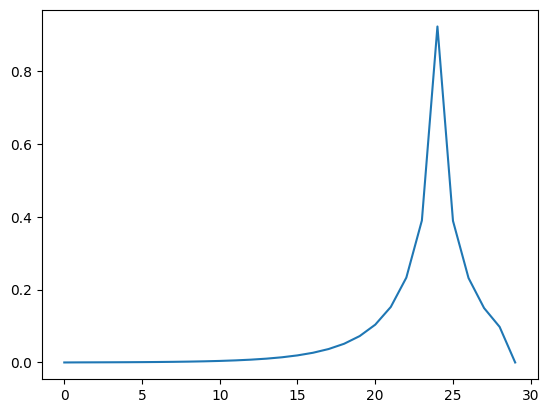

In [63]:
import copy
psi2 = psi.copy()

                # vL i vR | i i*
psi2.Bs[5] = np.tensordot(psi2.Bs[5],sigmaX,[1, 1]).transpose([0,2, 1]) # vL vR i
result = calc_contraction_func_final(sigmaX, psi, psi2)
print(result)

plt.plot(result)



In [91]:
#check
from c_tebd import run_TEBD 
from a_mps import init_spinup_MPS
import matplotlib.pyplot as plt
import copy

sigmaY = np.array([[0., 1j],[-1j, 0.]])
sigmaX = np.array([[0., 1.],[1., 0.]])

L = 20
g = 0.3
# t_final
J = 1


dt = 0.3j

model = TFIModel(L, J=J, g=g, h=0.)
U_bonds = calc_U_bonds(model, dt)


E_tmp, psi, model_tmp = example_TEBD_gs_finite(L, J, g)
gnd_state = psi.copy()
                # vL i vR | i i*
psi.Bs[L//2] = np.tensordot(psi.Bs[L//2],sigmaY,[1, 1]).transpose([0,2, 1]) # vL vR i
result = calc_contraction_func_final(sigmaY, psi, gnd_state)

corrs = [result]
ents = [psi.entanglement_entropy()]
for n in range(30):
    run_TEBD(psi, U_bonds, N_steps=1, chi_max=100, eps=1.e-10)
                    # vL i vR | i i*
    # psi.Bs[5] = np.tensordot(psi.Bs[5],sigmaY,[1, 1]).transpose([0,2, 1]) # vL vR i
    result = calc_contraction_func_final(sigmaY, psi, gnd_state)
    ents.append(psi.entanglement_entropy())
    corrs.append(result)

print(result)


finite TEBD, (imaginary time evolution)
L=20, J=1.0, g=0.30
dt = 0.10000: E = -19.4977160828055
dt = 0.01000: E = -19.4980742014568
dt = 0.00100: E = -19.4981103981870
dt = 0.00010: E = -19.4981140250708
dt = 0.00001: E = -19.4981143877480
final bond dimensions:  [2, 4, 8, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 8, 4, 2]


/tmp/ipykernel_38728/4111334070.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(result)


[-1.18520769e-06+1.39100203e-06j  6.63605148e-05+3.72619199e-05j
  1.22746914e-05-5.58295183e-04j -2.75558526e-03+2.59756322e-03j
  1.38306130e-02-2.38061048e-03j -4.18062326e-02-1.53071844e-02j
  4.74162312e-02+4.29135388e-02j -3.42781115e-02-5.40440745e-02j
  2.36969407e-02+5.99515445e-02j -2.21735810e-02-6.56319118e-02j
  2.36973364e-02+5.99495824e-02j -2.91602470e-02-4.84734794e-02j
  4.74071800e-02+4.29129519e-02j -3.27227849e-02-1.13127197e-02j
  1.38450843e-02-2.38273442e-03j -1.86356398e-03+2.10893207e-03j
  2.39661853e-05-5.21828701e-04j  3.14009662e-05+5.89315916e-05j
 -4.33551924e-05+2.64636677e-06j -3.74757332e-19+3.23639300e-19j]


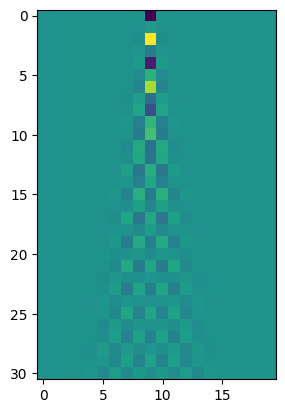

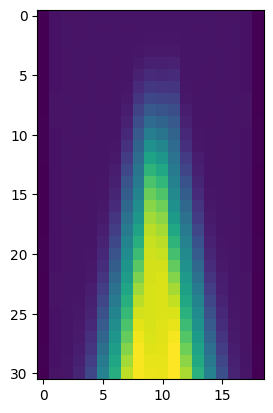

In [92]:

plt.imshow(np.array(corrs).real)
plt.figure()
plt.imshow(ents)
